In [108]:
import faiss                            
from torchvision import transforms

import datasets as datasets
import datasets.cub200 as cub200
import architectures as archs
import os, sys, numpy as np, argparse, imp, datetime, pandas as pd, copy
import time, pickle as pkl, random, json, collections
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

from tqdm import tqdm

import parameters    as par

import numpy as np
from matplotlib import pyplot as plt
import datasampler   as dsamplers
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from PIL import Image
import torchvision.transforms.functional as TF

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [109]:
args = argparse.Namespace(
    loss="triplet",
    batch_mining="softmargin",
    log_online=True,
    project="DML_project",
    group="cub200lt",
    seed=0,
    gpu=7,
    bs=112,
    data_sampler="lt",
    samples_per_class=2,
    arch="resnet50_frozen_normalize",
    source="/hdd/hdd3/kjb/dataset",
    n_epochs=150,
    lr=0.00001,
    embed_dim=128,
    evaluate_on_gpu=True,
    imb_factor=1.0,
    savename="test"
)

In [110]:
################### INPUT ARGUMENTS ###################
parser = argparse.ArgumentParser()

parser = par.basic_training_parameters(parser)
parser = par.batch_creation_parameters(parser)
parser = par.batchmining_specific_parameters(parser)
parser = par.loss_specific_parameters(parser)
parser = par.wandb_parameters(parser)

##### Read in parameters
opt = parser.parse_args(args=[])

In [111]:
datasets = cub200.Give(opt, '/hdd/hdd3/kjb/dataset/cub200')

spliting test data into [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10] number of datasets
spliting train data into [50, 50, 50, 50, 44, 41, 50, 48, 50, 50, 50, 50, 50, 50, 50, 50, 50, 45, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50

In [112]:
model      = archs.select('resnet50_frozen_normalize', opt)
model = model.to(device)
ckpt = torch.load('/home/lyj/cv2023_image_retrieval/checkpoints/model_epoch_150_if_1.0_sp_lt_bm_softhard.pth')
model.load_state_dict(ckpt)


<All keys matched successfully>

In [113]:
test_image_lst = []
labels = []
for item in datasets['testing'].image_list:
    test_image_lst.append(item[0])
    labels.append(item[1])

In [115]:
import faiss    
faiss_index = faiss.IndexFlatL2(128)   # build the index

# storing the image representations
im_indices = []

with torch.no_grad():
    for image_path in test_image_lst:
        image = Image.open(image_path)
        transformed_image = transform(image).cuda()
        if transformed_image.shape[0] == 3:
            preds = model(transformed_image.unsqueeze(0))[0]
            preds = np.array([preds[0].cpu().numpy()])
            faiss_index.add(preds) 
            im_indices.append(image_path)    

[[   0  436  596  430  713   21  922  628  242  441 1077  623  434 1437
  1449  704    7  621  851 1460 1465 1425  998  587  659   49 1003  597
   612  586   16  928 1006  603  908  522 1001  642  889  645  438 1429
  1422  590 1052 1421  648  598  839  591 1461  655 1075  627   12  583
  1002   29  853 1398  652  716 1432  605  633  581  647  913 1446  602
   584  620  304  497    4  644 1431  600 1441  657  715  838 1453 1467
   294  832 1462  585  516 1073  712  601  837  595 1417 1419 1447  831
  1418 1427]]
Retrieved Image: /hdd/hdd3/kjb/dataset/cub200/images/001.Black_footed_Albatross/Black_Footed_Albatross_0078_796126.jpg


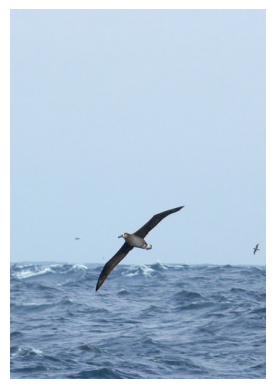

In [120]:
query_image = Image.open(test_image_lst[0])
transformed_query_image = transform(query_image).cuda()

test_embed = model(transformed_query_image.unsqueeze(0))[0].detach().cpu().numpy()
_, I = faiss_index.search(test_embed, 5)
print(I)
print("Retrieved Image: {}".format(im_indices[I[0][0]]))
        
        
%matplotlib inline
retrieved_image_path = im_indices[I[0][1]]
retrieved_images = Image.open(retrieved_image_path)

# Plot the NumPy array using Matplotlib
 
plt.imshow(query_image)# Assuming the image is in CHW format # (3, 224, 224) 
plt.axis('off')
plt.show()

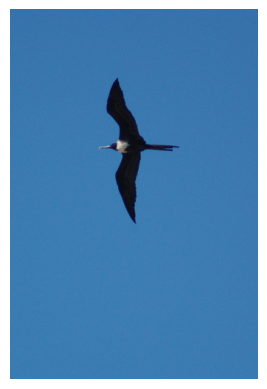

In [121]:
plt.imshow(retrieved_images) 
plt.axis('off')
plt.show()

In [122]:
datasets['testing'].image_list[0]

('/hdd/hdd3/kjb/dataset/cub200/images/001.Black_footed_Albatross/Black_Footed_Albatross_0078_796126.jpg',
 0)

In [124]:
print(im_indices[I[0][0]])
print(im_indices[I[0][1]])
print(im_indices[I[0][2]])
print(im_indices[I[0][3]])
print(im_indices[I[0][5]])

/hdd/hdd3/kjb/dataset/cub200/images/001.Black_footed_Albatross/Black_Footed_Albatross_0078_796126.jpg
/hdd/hdd3/kjb/dataset/cub200/images/044.Frigatebird/Frigatebird_0120_43300.jpg
/hdd/hdd3/kjb/dataset/cub200/images/060.Glaucous_winged_Gull/Glaucous_Winged_Gull_0133_44738.jpg
/hdd/hdd3/kjb/dataset/cub200/images/044.Frigatebird/Frigatebird_0112_43394.jpg
/hdd/hdd3/kjb/dataset/cub200/images/003.Sooty_Albatross/Sooty_Albatross_0070_796346.jpg


In [125]:
print(test_image_lst)

['/hdd/hdd3/kjb/dataset/cub200/images/001.Black_footed_Albatross/Black_Footed_Albatross_0078_796126.jpg', '/hdd/hdd3/kjb/dataset/cub200/images/001.Black_footed_Albatross/Black_Footed_Albatross_0079_796122.jpg', '/hdd/hdd3/kjb/dataset/cub200/images/001.Black_footed_Albatross/Black_Footed_Albatross_0080_796096.jpg', '/hdd/hdd3/kjb/dataset/cub200/images/001.Black_footed_Albatross/Black_Footed_Albatross_0081_426.jpg', '/hdd/hdd3/kjb/dataset/cub200/images/001.Black_footed_Albatross/Black_Footed_Albatross_0082_796121.jpg', '/hdd/hdd3/kjb/dataset/cub200/images/001.Black_footed_Albatross/Black_Footed_Albatross_0085_92.jpg', '/hdd/hdd3/kjb/dataset/cub200/images/001.Black_footed_Albatross/Black_Footed_Albatross_0086_796062.jpg', '/hdd/hdd3/kjb/dataset/cub200/images/001.Black_footed_Albatross/Black_Footed_Albatross_0088_796133.jpg', '/hdd/hdd3/kjb/dataset/cub200/images/001.Black_footed_Albatross/Black_Footed_Albatross_0089_796069.jpg', '/hdd/hdd3/kjb/dataset/cub200/images/001.Black_footed_Albatro